# A model to classify Twitter text related to natural disasters

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
from fastai.text import *

In [16]:
from glob import glob

## Language model

Watch batch size; language models use a lot of GPU.

In [17]:
bs=48

In [18]:
df = pd.read_csv('/home/jmn21373/.fastai/data/CrisisNLP_labeled_data_crowdflower/2014_California_Earthquake/2014_california_eq.csv')

In [19]:
data_lm = (TextList.from_df(df=df, cols = "tweet_text")
           #Inputs: all the text files in path
            #.filter_by_folder(exclude=['readme']) 
           # Exclude readme.txt.  Oh well.
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm_crisisNLP.pkl')

Since I didn't specify a path, it puts pickled file in the default path, which is the same as this notebook, i.e., /home/jmn21373/course-v3/nbs/dl1

In [20]:
data_lm = load_data('/home/jmn21373/course-v3/nbs/dl1', 'data_lm_crisisNLP.pkl', bs=bs)

In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [22]:
learn.summary

<bound method model_summary of LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1812 items)
x: LMTextList
xxbos xxup rt @nicoleewayne : xxmaj xxunk xxup usa xxmaj xxunk http : / / t.co / xxunk # earthquake xxup breaking xxup news xxunk earthquake xxmaj northern xxmaj california braces for xxunk ¦,xxbos xxup rt @sfgate : xxmaj we 're xxunk this interactive map of reported damage from the # xxmaj napaquake . xxmaj check it out : http : / / t.co / xxunk http : / / t.co / xxunk ¦,xxbos xxup rt xxunk : xxmaj strong 6.1 xxmaj earthquake xxmaj rocks xxmaj san xxmaj francisco xxmaj bay xxmaj area , xxmaj injures 87 + , xxmaj significant xxmaj damage xxmaj in xxmaj napa http : / / t.co / xxunk,xxbos xxup rt @heyyouapp : xxmaj xxunk xxup usa xxmaj xxunk http : / / t.co / 4lbyereec9 xxup breaking xxup news xxunk earthquake 6.0 earthquake jolts xxmaj bay xxmaj area damage and at least â€ ¦,xxbos xxup rt @scullather : " @infodude : amazing use of # bigdata from @jawbone - xxmaj how the xxma

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


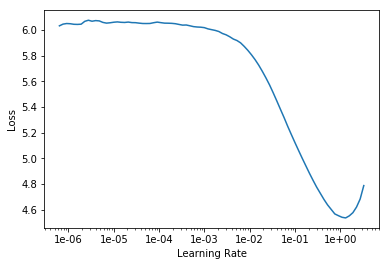

In [20]:
learn.recorder.plot()

In [23]:
bs =48

In [24]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
learn.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,3.304577,2.266029,0.537202,00:02


In [ ]:
# After fit one cycle is done, try running this to return accuracy and see if it matches:
learn.validate()

53% accuracy is actually a very good result.  Generic models get 30% and specialized models can get 50% or so.  

In [25]:
learn.save_encoder('crude_enc')

## Classifier

In [26]:
bs = 96

Whoops.  Got a NaN error first time I ran this because I did not drop the rows with NaN in the "text_human" label.  Oops.  I knew that, just forgot.

In [27]:
df.dropna(subset=['choose_one_category'], inplace=True)

In [28]:
data_clas = (TextList.from_df(df=df, cols = "tweet_text", vocab=data_lm.vocab)
           .split_by_rand_pct(0.1)
           #We split by Boolean in is_valid column (True or False)
           .label_from_df(cols= "choose_one_category")          
           #We label based on rating on Amazon (number of stars)
           .databunch(bs=bs)
            )

In [29]:
data_clas.show_batch()

text,target
xxbos xxup rt xxunk : xxmaj xxunk xxup us xxunk xxmaj xxunk with xxup xxunk for xxmaj xxunk # xxmaj xxunk # xxmaj xxunk # xxmaj xxunk # xxup usa # xxmaj xxunk # xxup uk # xxup us # napaquake # xxunk http : / / t.co / â€ ¦,not_related_or_irrelevant
xxbos [ [ xxunk ™ ¥ # xxunk ™ ¥ ] ] xxup n. xxmaj california xxmaj earthquake xxmaj damage xxmaj could xxmaj reach $ xxup 1b : xxmaj northern xxmaj cali ... http : / / t.co / xxunk [ [ xxunk ™ ¥ # xxunk ™ ¥ ] ],other_useful_information
xxbos xxup rt @fabiankeiser : xxmaj the xxmaj ring of xxmaj fire gets angry ? xxmaj yesterday # xxmaj earthquake in # xxmaj chile ( 6.6 ) . xxmaj today in # xxmaj california ( 6.0 ) and now # xxmaj peru ( 7.0 ) . http : â€ ¦,other_useful_information
xxbos xxup rt @fabiankeiser : xxmaj the xxmaj ring of xxmaj fire gets angry ? xxmaj yesterday # xxmaj earthquake in # xxmaj chile ( 6.6 ) . xxmaj today in # xxmaj california ( 6.0 ) and now # xxmaj peru ( 7.0 ) . http : â€ ¦,other_useful_information
xxbos xxmaj jawbone xxmaj looks xxmaj at xxup up xxmaj data xxmaj to xxmaj see xxmaj how xxmaj many xxmaj were xxmaj woken xxmaj up xxmaj by xxmaj the xxmaj napa xxmaj earthquake : xxmaj jawbone has xxunk one of the xxunk ... http : / / t.co / xxunk,other_useful_information


In [30]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('crude_enc')

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


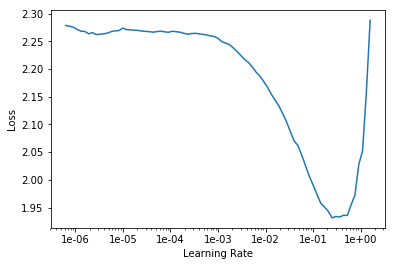

In [32]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(1, 5e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.966541,3.171141,0.139303,00:02


In [32]:
learn.fit_one_cycle(4, 5e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.582205,2.541943,0.308458,00:02
1,2.536399,9.827305,0.104478,00:02
2,3.380110,1.823593,0.313433,00:02
3,2.615143,1.328453,0.567164,00:02


In [33]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.310188,1.163405,0.601990,00:02


In [34]:
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.175806,1.071941,0.626866,00:02
1,1.188289,2.666165,0.572139,00:02
2,1.130666,1.040957,0.621891,00:02
3,1.077769,1.000748,0.671642,00:02


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.990146,0.949213,0.661692,00:02


In [36]:
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.902652,1.402444,0.716418,00:02
1,0.850839,0.932097,0.721393,00:02
2,0.812127,0.830578,0.766169,00:02
3,0.770328,0.825714,0.766169,00:02


Imran reports accuracy = 76.85 for California earthquake using event-only data in "Rapid Classification of Crisis-Related Data on Social Networks using Convolutional Neural Networks" In Proceedings of the 11th International AAAI Conference on Web and Social Media (ICWSM), 2017, Montreal, Canada. When he adapts and uses out of event data, he can get 80.19.  

By comparison, inter-annotator agreement (agreement between human labelers) for California earthquake data is 0.85.

I am getting close to SOA results with very little work. 

In [37]:
learn.save("fourth")

NOTE:  It looks like I can't get F1 score because you have to define metrics when you create the learner.  So if I wanted F1 score, I would need to declare that when I create the learner.  I think.

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

/home/jmn21373/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


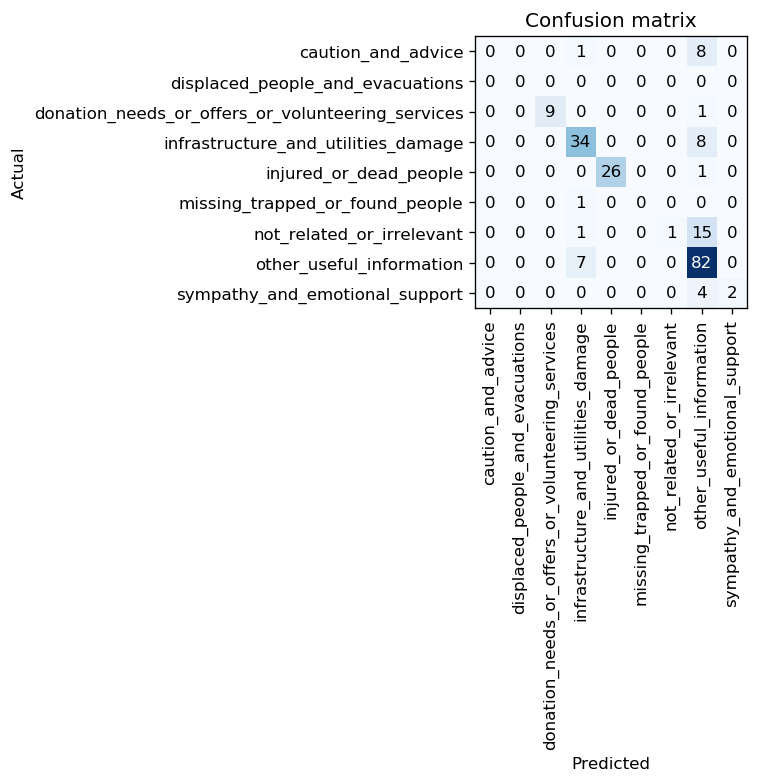

In [40]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=120)